In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
fire_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)
fire_data <- slice(fire_data, 1:122) %>%
    mutate(Classes = as_factor(Classes)) %>%
    mutate(across(Temperature:FWI, as.double))
fire_data

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,not fire
29,09,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire
30,09,2012,25,78,14,1.4,45.0,1.9,7.5,0.2,2.4,0.1,not fire


In [10]:
set.seed(1)


fire_split <- initial_split(fire_data, prop = 0.7, strata = Classes)
fire_training <- training(fire_split)
fire_test <- testing(fire_split)

fire_training 

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
26,09,2012,31,54,11,0.0,82.0,6.0,16.3,2.5,6.2,1.7,not fire
27,09,2012,31,66,11,0.0,85.7,8.3,24.9,4.0,9.0,4.1,fire
29,09,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire


In [6]:
class_counts <- fire_training %>%
    group_by(Classes) %>%
    summarize(n = n())
class_counts

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,45
fire,42


In [7]:
predictor_means <- fire_training %>%
    select(Temperature:FWI) %>%
    map_dfr(mean) %>%
    pivot_longer(cols = Temperature:FWI,
                 names_to = "Predictor",
                 values_to = "Mean")
predictor_means

Predictor,Mean
<chr>,<dbl>
Temperature,31.14943
RH,67.95402
Ws,15.94253
⋮,⋮
ISI,3.690805
BUI,15.943678
FWI,5.733333


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


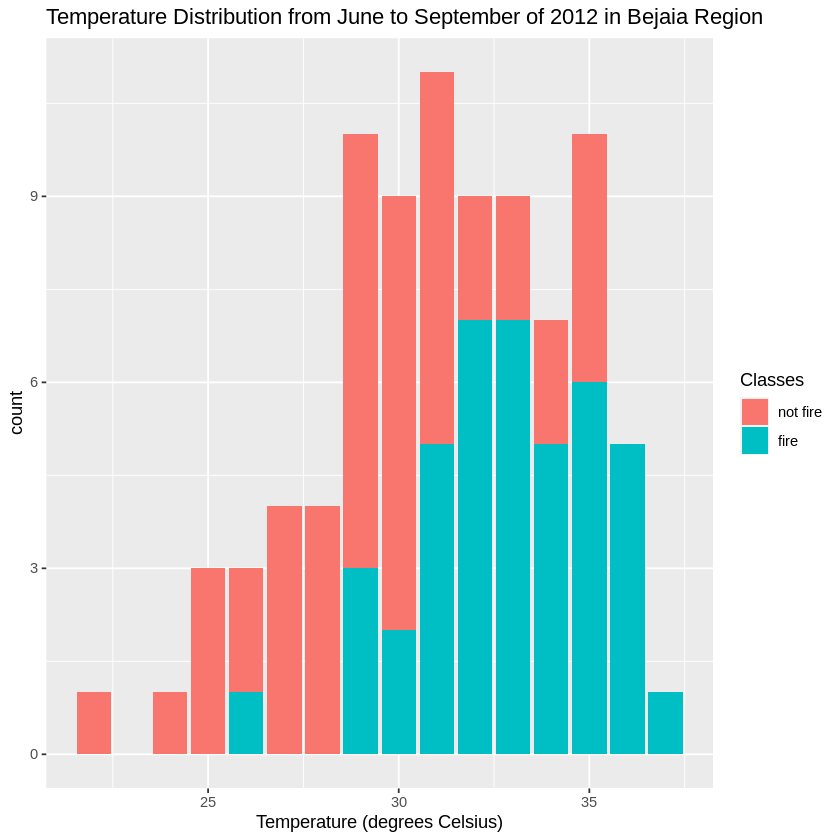

In [8]:
# added fill for all of these, but how do we want to parse it out, stack or dodge or smth else?
# can we swap the colors for these graphs? 

temp_dstn_plot <- fire_training %>%
    ggplot(aes(x = Temperature, fill = Classes)) + 
    geom_histogram(stat = "count") +
    labs(x = "Temperature (degrees Celsius)") + 
    ggtitle("Temperature Distribution from June to September of 2012 in Bejaia Region")
temp_dstn_plot

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


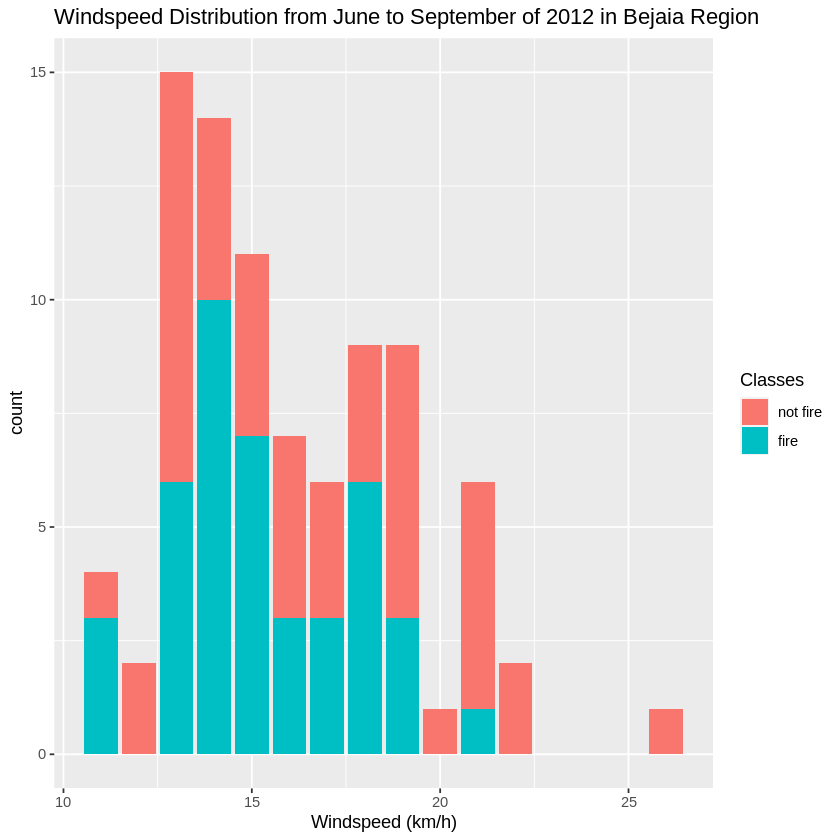

In [9]:
ws_dstn_plot <- fire_training %>%
    ggplot(aes(x = Ws, fill = Classes)) + 
    geom_histogram(stat = "count") +
    labs(x = "Windspeed (km/h)") + 
    ggtitle("Windspeed Distribution from June to September of 2012 in Bejaia Region")
ws_dstn_plot

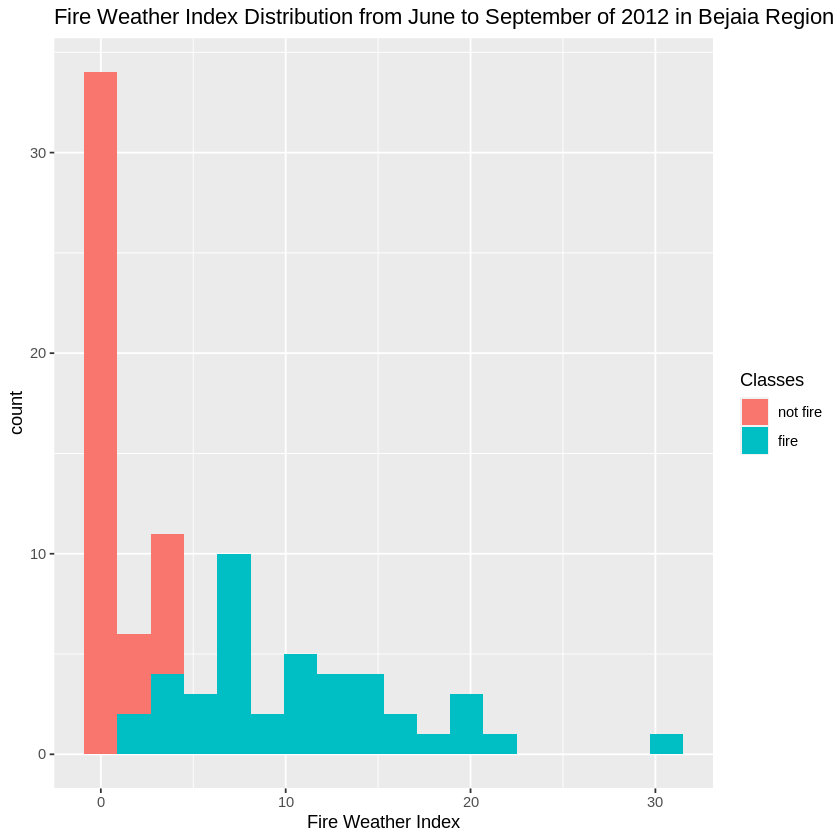

In [5]:
# this is my modification of the last histogram. needed to remove the stat = "count" to get binwidth to work
# since histos default to the count, you don't actually need to add that argument
# we can decide whether to keep it for the other histos, cause that's what puts space btwn the bars

FWI_dstn_plot <- fire_training %>%
    ggplot(aes(x = FWI, fill = Classes)) + 
    geom_histogram(binwidth = 1.8) +
    labs(x = "Fire Weather Index") + 
    ggtitle("Fire Weather Index Distribution from June to September of 2012 in Bejaia Region")
FWI_dstn_plot